# Mastodon Speed Analysis
The goal of this notebook is to provide examples of a framework for analyzing the tracking data produced by Mastodon. This analysis assumes that track splitting and merging were *not* allowed (i.e., no lineage tracing). The outputs of this script include reorganized tables of tracking information and figures reflecting features of the tracking.

## Exporting data from Mastodon
Starting from tracks in Mastodon, choose the `compute features` option on the main Mastodon menu.  Make sure all options are checked, and then click the `Compute` button. This could take some time. Once this completes, click on the `table` button on the main Mastodon menu.  With the `Spot` option on the left of the menu selected, go to `File > Export to CSV` and save this file somewhere you can find it. Note that mastodon will auto-add the phrase "-Spot" to the end of your file name. Now click on the `Link` option on the far side of the table, and again `Export to CSV` using the same file name. In this case, Mastodon will auto-add the phrase "-Link" to the end of your file name.  Together, these two files describe your tracks and the following analysis will provide examples of how to work with them to measure things like speed.

## Set up and Parameters
First, set up the notebook by importing the correct libraries and setting your parameters.

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt                       # for plotting
import pandas as pd                                   # for loading the Mastodon output
from mpl_toolkits.mplot3d import Axes3D               # for 3D plotting

print('Set up complete')

Set up complete


In [2]:
# Parameters
frameRate = 3 #minutes per frame
minLength = 10 # remove spurious tracks by insisting they exist for a non-trivial number of frames

# Make sure each file is described by the full path
mainDir = 'Y:/instruments/Rachel/forRyan/Trial10/fused/'
spotsFile = mainDir + 'fused_algae_MastodonTable-Spot.csv'
linksFile = mainDir + 'fused_algae_MastodonTable-Link.csv'

## Load the Data

Next, load in the relevant Mastodon data files and set the appropriate imaging parameters. I will start by focusing on the algae and consider potential tissue motion later.

In [3]:
spots =  pd.read_csv(spotsFile, header = [0, 1, 2]) # the csv has three rows of header information

# The structure of Mastodon csvs leads to some clunky column names. We'll fix them here for simplicity later.
spots = spots.rename(columns=
                     {'Unnamed: 0_level_1': ' ', 'Unnamed: 0_level_2': ' ','Unnamed: 1_level_1': ' ', 'Unnamed: 1_level_2':' ','Unnamed: 2_level_2':' ',
                     'Unnamed: 3_level_2':' ','Unnamed: 6_level_2':' ','Unnamed: 25_level_2':' ','Unnamed: 26_level_2':' '})

# optionally display first 5 rows of data to confirm that the loaded data makes sense
print('Spots Information')
print(spots.shape)
spots.head()

Spots Information
(17866, 27)


Label ID Detection quality Spot N links Spot center intensity               \
                                                     Center ch1   Center ch2   
                                                       (Counts)     (Counts)   
0     0  0       1463.769070            0            578.992445  2609.091735   
1     1  1        526.971928            0            577.614003  2553.569060   
2     2  2        712.387228            1            423.307200  2869.121041   
3     3  3       1971.428003            1            587.725575  3948.136214   
4     4  4       1435.211386            1            525.836422  3105.931898   

  Spot frame Spot intensity                      ...                         \
                   Mean ch1    Std ch1  Min ch1  ... Median ch2     Sum ch2   
                   (Counts)   (Counts) (Counts)  ...   (Counts)    (Counts)   
0          0     569.036145  54.005458    372.0  ...     2263.0  13071205.0   
1          0     576.753054  42.587467    439.0  ...     2516.0  14293026.0   
2          0     422.749041  29.870386    323.0  ...     2757.0  15912310.0   
3          0     587.217786  39.252292    447.0  ...     3604.0  20635095.0   
4          0     522.763089  42.396466    400.0  ...     2742.0  16166464.0   

  Spot position                          Spot quick mean               \
              X            Y           Z        Mean ch1     Mean ch2   
           (um)         (um)        (um)        (Counts)     (Counts)   
0    151.310138   820.984377   97.490601      569.036145  2282.382574   
1    310.090278   526.671051  119.397880      576.753054  2494.419895   
2    130.025602  1328.394657  124.034481      422.749041  2773.145695   
3    324.372867   420.075087  163.370622      587.217786  3598.098518   
4    115.298926  1230.165396  157.477662      522.763089  2830.758886   

  Spot radius Spot track ID Track N spots  
                                           
         (um)                              
0        20.0             0             1  
1        20.0          1749             1  
2        20.0             3             3  
3        20.0          1747            26  
4        20.0          1746            38  

[5 rows x 27 columns]

In [4]:
links =  pd.read_csv(linksFile, header = [0, 1, 2])

# The structure of Mastodon csvs leads to some clunky column names. We'll fix them here for simplicity later.
links = links.rename(columns=
                     {'Unnamed: 0_level_1': ' ', 'Unnamed: 0_level_2': ' ', 'Unnamed: 1_level_1': ' ', 'Unnamed: 1_level_2':' ','Unnamed: 2_level_2':' ', 'Unnamed: 4_level_2':' ', 'Unnamed: 5_level_2':' '})

# optionally display first 5 rows of data to confirm that the loaded data makes sense
print('Links Information')
print(links.shape)
links.head()

Links Information
(16116, 7)


Label ID   Link cost Link displacement Link target IDs  \
                                                 Source spot id   
                                           (um)                   
0  1587 ? 1800  0  386.346404         12.892449          1800.0   
1  1585 ? 1796  1   15.101838          3.652881          1796.0   
2  1584 ? 1795  2   24.326990          4.175087          1795.0   
3  1583 ? 1794  3   11.492452          2.659162          1794.0   
4  1582 ? 1792  4   54.725533          6.536474          1792.0   

                 Link velocity  
  Target spot id                
                    (um/frame)  
0         1587.0     12.892449  
1         1585.0      3.652881  
2         1584.0      4.175087  
3         1583.0      2.659162  
4         1582.0      6.536474

## Linking the tables
Right now, the information about each algea is in one variable (spots) and the information about motion from frame to frame is in another variable (links). What we would like is for each algea to know the speed over time (and the mean speed), which requires linking these two variables. The following links together a subset of each variable. This will result in a data frame that is more easily human readable, and that will also facilitate asking questions about each track.

In [5]:
# Make a subset of the links data for our combined variable
linkedSpots = links.loc[:,["Link displacement","Link target IDs"]]
# For merging across levels, we'll simplify the headers
linkedSpots.columns = [' '.join(col).strip() for col in linkedSpots.columns.values]
linkedSpots = linkedSpots.rename(columns= {'Link target IDs Source spot id': 'Source ID', 'Link target IDs Target spot id': 'Target ID'})
# Make sure IDs are integers
linkedSpots['Source ID'] = linkedSpots['Source ID'].astype(int)
linkedSpots['Target ID'] = linkedSpots['Target ID'].astype(int)

# # optionally look at resulting structure as a check
# linkedSpots.head()

In [6]:
# For readability, focus on most relevant metrics of the spots
spotsForLinks = spots.loc[:,["ID","Spot frame","Spot intensity","Spot position","Spot track ID","Track N spots"]]
# focus on the mean intensty for the purposes here (and for readability)
spotsForLinks = spotsForLinks.iloc[:,[0,1,2,8,14,15,16,17,18]] # easier to count columns now rather than list all the names
# For merging across levels, we'll simplify the headers
spotsForLinks.columns = [' '.join(col).strip() for col in spotsForLinks.columns.values]
spotsForLinks = spotsForLinks.rename(columns= {'ID': 'Spot ID','Spot intensity Mean ch1 (Counts)': 'Mean ch1', 'Spot intensity Mean ch2 (Counts)': 'Mean ch2'})

# # optionally look at resulting structure as a check
# spotsForLinks.head()

In [7]:
# Add the source spot to the linkedSpots
linkedSpots = pd.merge(linkedSpots, spotsForLinks,
                       how='left', left_on='Source ID', right_on='Spot ID')
# Rename to make it clear this is the source data
linkedSpots = linkedSpots.rename(columns= {'Spot ID': 'Source', 'Mean ch1': 'Mean ch1 - Source', 'Mean ch2': 'Mean ch2 - Source','Spot frame':'Source frame',
                                          'Spot position X (um)':'X Source (um)','Spot position Y (um)':'Y Source (um)','Spot position Z (um)':'Z Source (um)',
                                          'Spot track ID':'Source track','Track N spots':'N Source'})

# # optionally look at resulting structure as a check
# linkedSpots.head()

In [8]:
# Add the target spot to the linkedSpots
linkedSpots = pd.merge(linkedSpots, spotsForLinks,
                       how='left', left_on='Target ID', right_on='Spot ID')
# Rename to make it clear this is the source data
linkedSpots = linkedSpots.rename(columns= {'Spot ID': 'Target', 'Mean ch1': 'Mean ch1 - Target', 'Mean ch2': 'Mean ch2 - Target','Spot frame':'Target frame',
                                          'Spot position X (um)':'X Target (um)','Spot position Y (um)':'Y Target (um)','Spot position Z (um)':'Z Target (um)',
                                          'Spot track ID':'Target track','Track N spots':'N Target'})

# optionally save this as a csv that can be explored in other ways
linkedSpots.to_csv(mainDir+"algae_linkedSpots.csv",index = False)

# optionally look at resulting structure as a check
linkedSpots.head()

,Link displacement (um),Source ID,Target ID,Source,Source frame,Mean ch1 - Source,Mean ch2 - Source,X Source (um),Y Source (um),Z Source (um),...,N Source,Target,Target frame,Mean ch1 - Target,Mean ch2 - Target,X Target (um),Y Target (um),Z Target (um),Target track,N Target
0,12.892449,1800,1587,1800,8,371.214584,2628.028716,1359.466189,1075.077918,843.415589,...,8,1587,7,372.686546,3039.034380,1360.886575,1075.266896,830.603017,1285,8
1,3.652881,1796,1585,1796,8,378.399686,2367.916957,551.557256,2003.995498,813.760771,...,15,1585,7,371.389549,2304.162356,549.443464,2006.239849,815.719931,1674,15
2,4.175087,1795,1584,1795,8,531.960846,9178.382276,529.466198,1860.668253,811.817992,...,14,1584,7,535.343216,10009.514649,527.986647,1864.526502,811.221169,87,14
3,2.659162,1794,1583,1794,8,517.257243,2564.628970,637.036922,1605.710944,813.567565,...,4,1583,7,504.717077,2596.111634,637.773920,1607.661194,815.218171,1157,4
4,6.536474,1792,1582,1792,8,473.004733,7385.747239,499.676643,1990.210275,802.426621,...,74,1582,7,463.123448,6734.284315,496.065625,1994.248227,806.084623,1663,74


## Sanity Checks

This table includes tracks that are too short. Anything that is only a few frames long is likely spurious, and will lead to confusion in the later analysis. Let's look at the distribution and use it to set a minimum track length

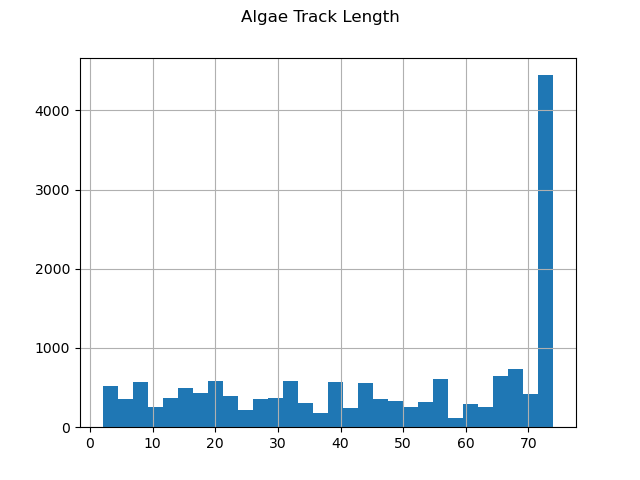

In [9]:
fig = plt.figure(1)
axs = fig.add_subplot()                                        
plt.clf()
linkedSpots["N Source"].hist(bins=30) 
axs.set_xlabel("Track Length (frames)")
axs.set_ylabel("Count") 
fig.suptitle('Algae Track Length')
plt.show()  

In [10]:
print('Before removing short tracks:')
print('Number of spots: ', linkedSpots.shape[0])
Ntracks = linkedSpots["Target track"].unique()
print('Number of tracks: ', Ntracks.shape[0])

linkedSpots = linkedSpots[linkedSpots["N Source"]>minLength]

print('')
print('After removing short tracks:')
print('Number of spots: ', linkedSpots.shape[0])
Ntracks = linkedSpots["Target track"].unique()
print('Number of tracks: ', Ntracks.shape[0])

Before removing short tracks:
Number of spots:  16116
Number of tracks:  890

After removing short tracks:
Number of spots:  14557
Number of tracks:  396


To double check the above makes sense (as a check on our understanding of the Mastodon file format), double check that the merged values line up appropriately.

In [11]:
# A sanity check: Do the track IDs agree?
badLinks = linkedSpots[linkedSpots["Source track"]!=linkedSpots["Target track"]]
print('The shape of badLink should have zero rows: ', badLinks.shape)

The shape of badLink should have zero rows:  (0, 21)


In [12]:
# A sanity check: Do the displacements agree?
badDisp = linkedSpots
badDisp["Calc displacement"] = ((badDisp["X Source (um)"]-badDisp["X Target (um)"])**2 + (badDisp["Y Source (um)"]-badDisp["Y Target (um)"])**2 + (badDisp["Z Source (um)"]-badDisp["Z Target (um)"])**2)**0.5
# Difference in the displacements
badDisp = badDisp.iloc[:,0]-badDisp["Calc displacement"];
# There will be some amount of rounding error, small values are acceptable
badDisp.describe()

count    1.455700e+04
mean    -5.595312e-16
std      1.059758e-13
min     -6.963319e-13
25%     -2.842171e-14
50%      0.000000e+00
75%      2.842171e-14
max      7.576162e-13
dtype: float64

## Speed measurements
All of the above set up makes it easy to quickly look at the speed per track

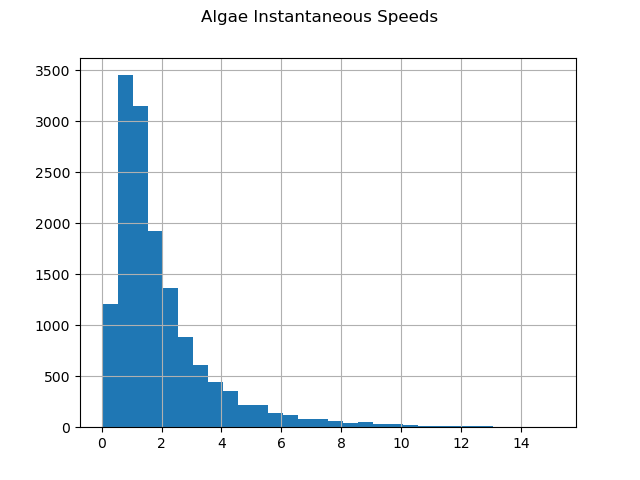

In [13]:
# First, put speed into useful units
linkedSpots["dt (frames)"] = linkedSpots["Source frame"]-linkedSpots["Target frame"] # mostly dt = 1,  but with gap closing it can equal 2
linkedSpots["Speed (um/min)"] = linkedSpots.iloc[:,0]/linkedSpots["dt (frames)"]/frameRate

# Make a histogram of instantaneous speed
fig = plt.figure(2)
axs = fig.add_subplot()                                        
plt.clf()
linkedSpots["Speed (um/min)"].hist(bins=30) 
axs.set_xlabel("Speed ($\\mu$m/min)")
axs.set_ylabel("Count") 
fig.suptitle('Algae Instantaneous Speeds')
plt.show()  

fig.savefig(mainDir + "AlgaeInstantaneousSpeedDistribution.png")

Next, we can group the speeds by track to look at variability across the algea.

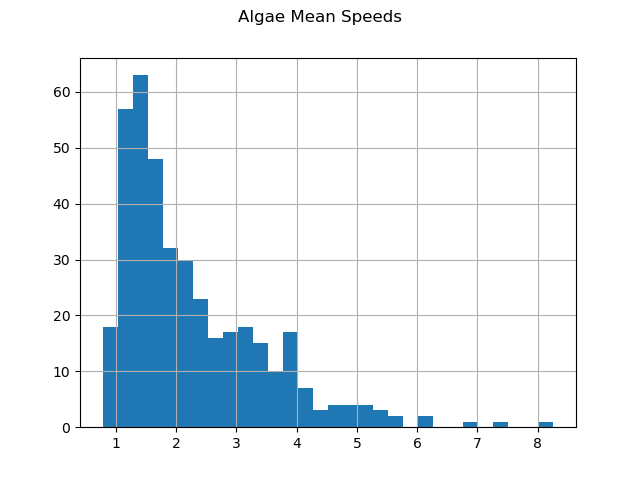

In [14]:
meanSpeed = linkedSpots[["Source track","Speed (um/min)"]].groupby("Source track").agg(["mean","std"])
meanSpeed.columns = meanSpeed.columns.droplevel()

# Save this data to be explored
meanSpeed.to_csv(mainDir+"algea_meanSpeed.csv",index=False)

# Make a histogram of mean speed
fig = plt.figure(3)
axs = fig.add_subplot()                                        
plt.clf()
meanSpeed["mean"].hist(bins=30)
axs.set_xlabel("Speed ($\\mu$m/min)")
axs.set_ylabel("Count") 
fig.suptitle('Algae Mean Speeds')
plt.show()  

fig.savefig(mainDir + "AlgaeMeanSpeedDistribution.png")

We can also look at the speed values spatially using the spot location information. Note that you can drag these figures to change the angle, but if there are a lot tracks the responsiveness might be slow.

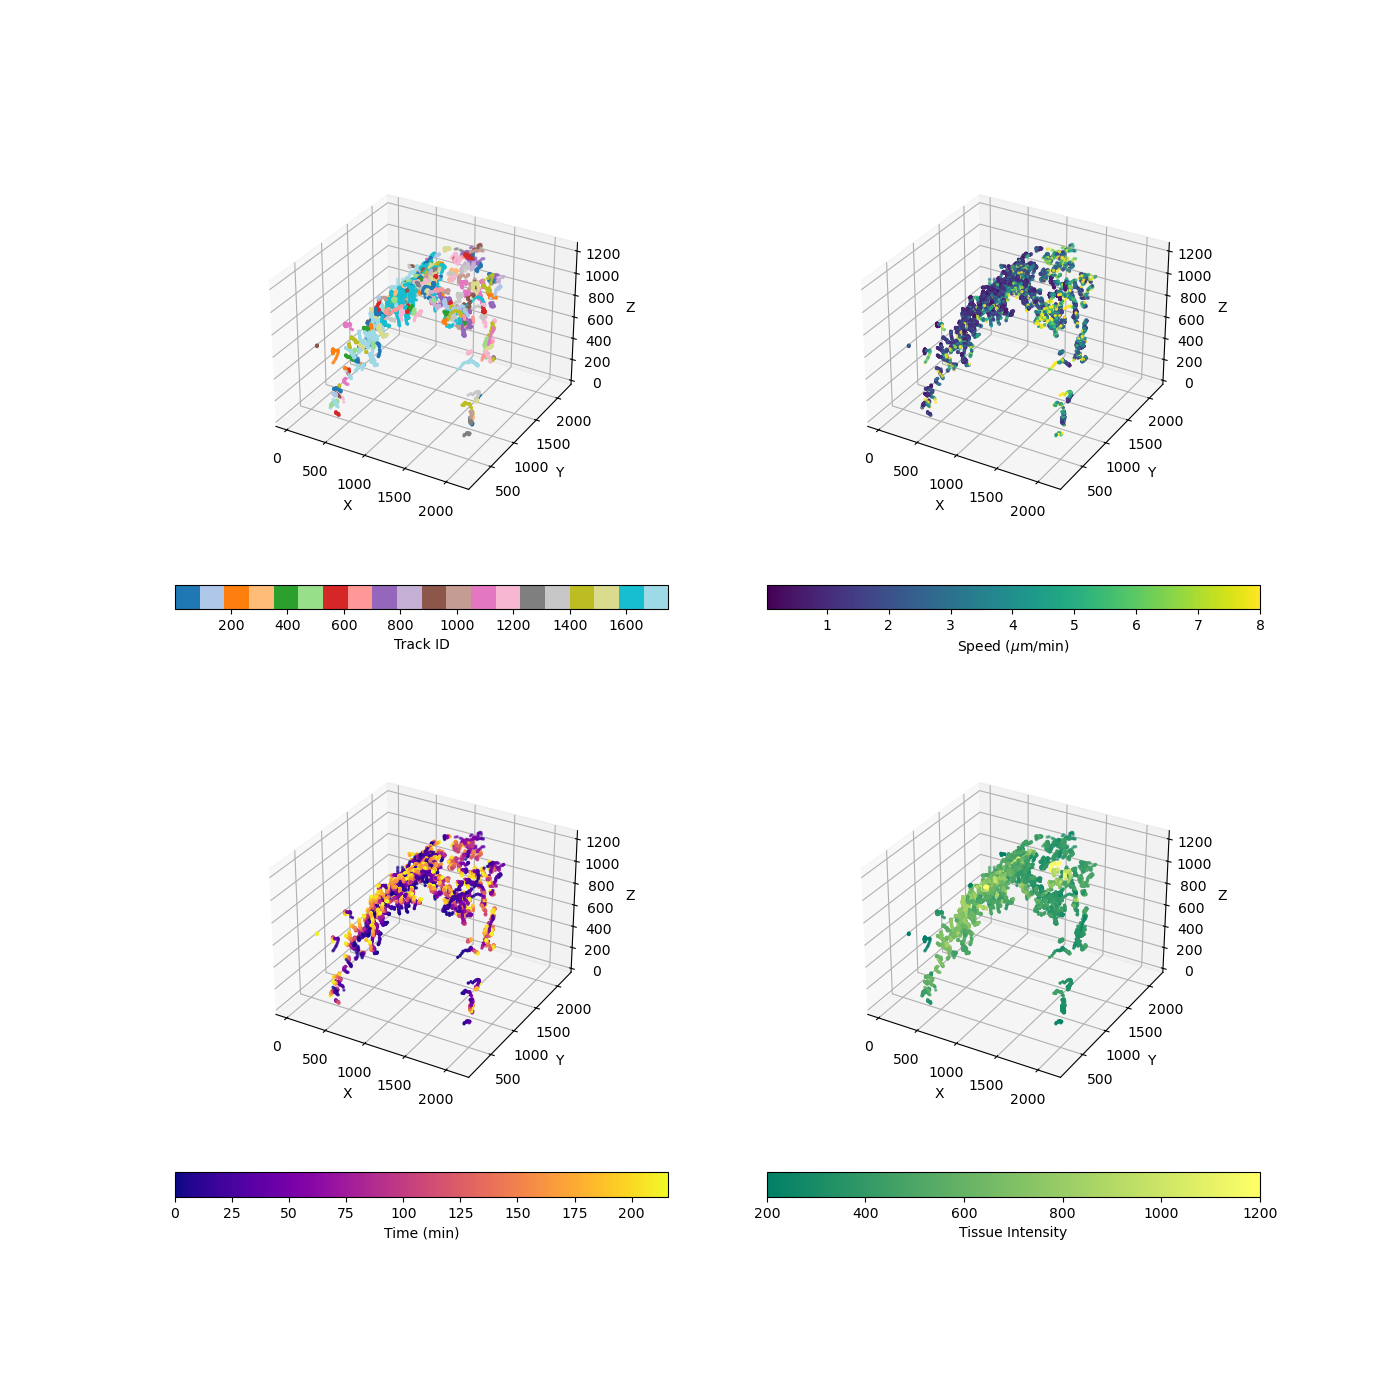

In [15]:
fig = plt.figure(4)
fig.set_size_inches(14,14)
plt.clf()

# Color by track ID
ax = fig.add_subplot(2,2,1, projection='3d',xlabel='X',ylabel='Y',zlabel='Z')
p = plt.scatter(x=linkedSpots["X Source (um)"], y=linkedSpots["Y Source (um)"], zs=linkedSpots["Z Source (um)"],
            s=2,c=linkedSpots["Target track"],cmap='tab20')
fig.colorbar(p,orientation='horizontal',label="Track ID")

# Color by instantaneous speed
ax = fig.add_subplot(2,2,2, projection='3d',xlabel='X',ylabel='Y',zlabel='Z')
p = plt.scatter(x=linkedSpots["X Source (um)"], y=linkedSpots["Y Source (um)"], zs=linkedSpots["Z Source (um)"],
            s=2,c=linkedSpots["Speed (um/min)"],vmax=8)
fig.colorbar(p,orientation='horizontal',label="Speed ($\\mu$m/min)")

# Color by time
ax = fig.add_subplot(2,2,3, projection='3d',xlabel='X',ylabel='Y',zlabel='Z')
p = plt.scatter(x=linkedSpots["X Source (um)"], y=linkedSpots["Y Source (um)"], zs=linkedSpots["Z Source (um)"],
            s=2,c=linkedSpots["Target frame"]*frameRate,cmap='plasma')
fig.colorbar(p,orientation='horizontal',label="Time (min)")

# Color by Ch 1 intensity (what is the local tissue intensity compared to speed?)
ax = fig.add_subplot(2,2,4, projection='3d',xlabel='X',ylabel='Y',zlabel='Z')
p = plt.scatter(x=linkedSpots["X Source (um)"], y=linkedSpots["Y Source (um)"], zs=linkedSpots["Z Source (um)"],
            s=2,c=linkedSpots["Mean ch1 - Target"],cmap='summer',vmin=200,vmax=1200)
fig.colorbar(p,orientation='horizontal',label="Tissue Intensity")

plt.show()  

fig.savefig(mainDir + "AlgaeSpatialTracksByMultipleVariables.png")

We can also combine information to plot average track speed and the standard deviation of track speed spatially.

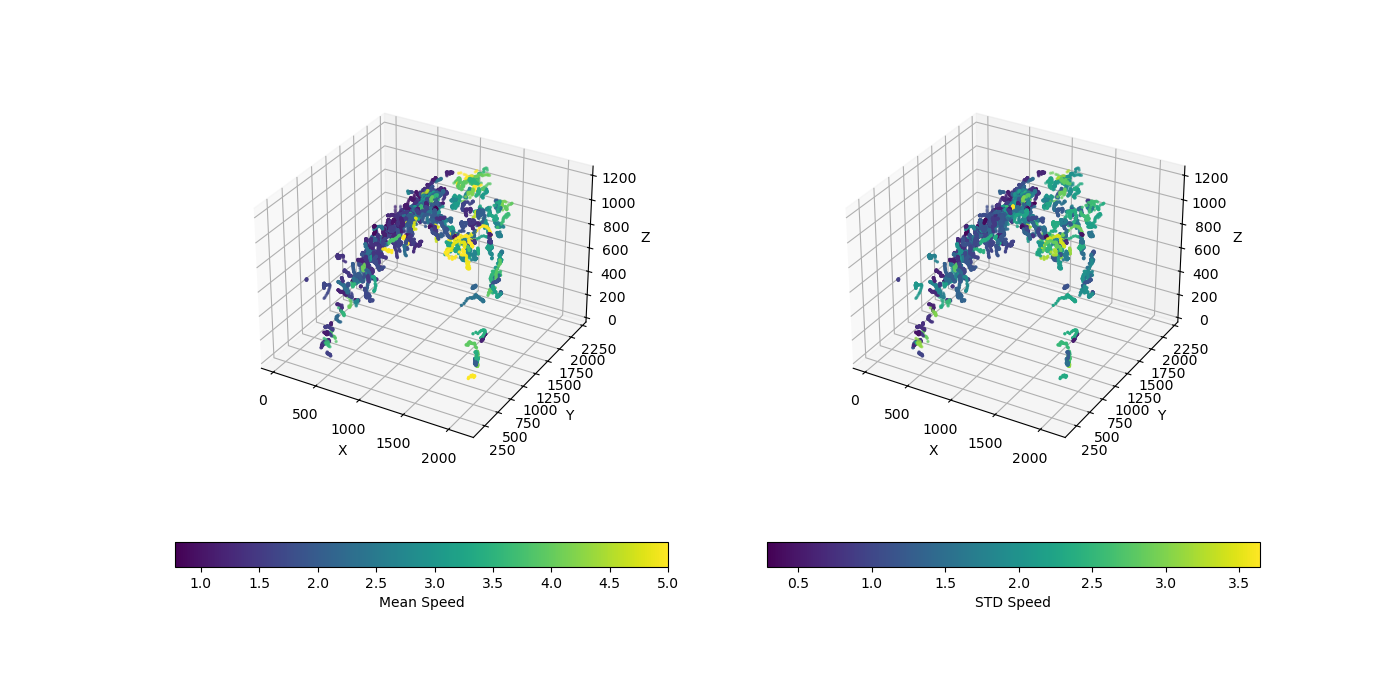

In [16]:
plotMean = pd.merge(linkedSpots, meanSpeed,
                       how='left', on='Source track')
# Rename to make it clear this is the source data
plotMean = plotMean.rename(columns= {'mean': 'Mean speed', 'std': 'STD speed'})

fig = plt.figure(5)
fig.set_size_inches(14,7)
plt.clf()

# Color by mean
ax = fig.add_subplot(1,2,1, projection='3d',xlabel='X',ylabel='Y',zlabel='Z')
p = plt.scatter(x=plotMean["X Source (um)"], y=plotMean["Y Source (um)"], zs=plotMean["Z Source (um)"],
            s=2,c=plotMean["Mean speed"],vmax=5)
fig.colorbar(p,orientation='horizontal',label="Mean Speed")

# Color by variability
ax = fig.add_subplot(1,2,2, projection='3d',xlabel='X',ylabel='Y',zlabel='Z')
p = plt.scatter(x=plotMean["X Source (um)"], y=plotMean["Y Source (um)"], zs=plotMean["Z Source (um)"],
            s=2,c=plotMean["STD speed"])
fig.colorbar(p,orientation='horizontal',label="STD Speed")

plt.show()  

fig.savefig(mainDir + "AlgaeSpatialTracksByMean.png")

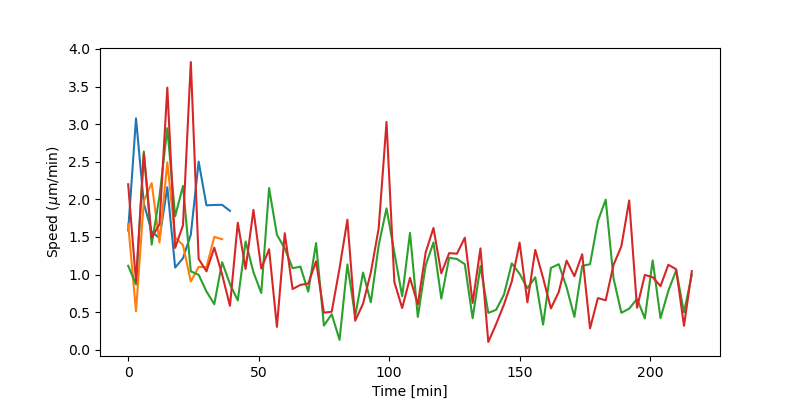

In [17]:
# Track time traces
# Line graphs are more interesting for only a few tracks
fig = plt.figure(6)
fig.set_size_inches(8,4)
plt.clf()

IDlist = [1674,87,1663,1667]

for idval in IDlist:

    # grab the information for this track
    thisTrack = linkedSpots["Target track"]==idval
    thisTrack = linkedSpots.loc[thisTrack,["Target frame","Speed (um/min)"]]
    thisTrack = thisTrack.sort_values(by='Target frame')

    # plot the line
    plt.plot(thisTrack['Target frame']*frameRate,thisTrack['Speed (um/min)'])

# Add formatting
plt.xlabel('Time [min]')
plt.ylabel('Speed ($\\mu$m/min)')

plt.show()

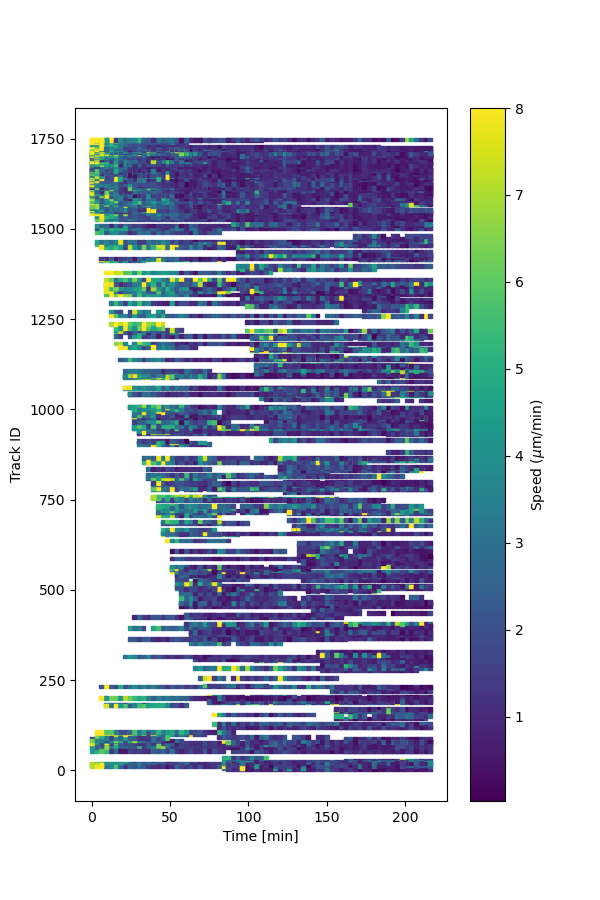

In [18]:
# To look at all the tracks, consider a heatmap instead
# This is a rough heatmap, prettier ones could also be made!
fig = plt.figure(7)
fig.set_size_inches(6,9)
plt.clf()

p = plt.scatter(linkedSpots["Target frame"]*frameRate,linkedSpots["Target track"],c=linkedSpots["Speed (um/min)"],
                s=7,marker='s',vmax=8)

# Add formatting
plt.xlabel('Time [min]')
plt.ylabel('Track ID')
fig.colorbar(p,label="Speed ($\\mu$m/min)")

# speedTraces = linkedSpots[["Target track","Target frame","Speed (um/min)"]]
# # speedTraces.sort_index().groupby(["Target track"]).head()
# # speedTraces = speedTraces.sort_index().groupby(["Target track"])
# speedTraces.pivot(columns="Target frame", values="Speed (um/min)").shape

plt.show()

fig.savefig(mainDir + "AlgaeSpeedVsTimeByTrack.png")